In [1]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
from torch import nn
from torch import optim
import progressbar
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import transforms
from torch import nn
from torch import optim
import progressbar
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
import torch
from torch.utils.data import DataLoader, Dataset
from CNN_tools import *
from CNN_UNET import *
from pytorch_lightning.callbacks import ModelCheckpoint
from DATALOADER import Pdf_Image_DataSet
from variables import *

In [ ]:
### LOAD ALL DATA ####

(image_test,pdf_test,pdf_filter_test) = load_data_test_all()
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)


Loading simu2 images ...
Done
Loading pdf simu2 ...
Pdf simu2 loaded
Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded


In [ ]:
(image_test.shape[0])/32

In [5]:
(image_test,pdf_test,pdf_filter_test) = (image_test[:-28],pdf_test[:-28],pdf_filter_test[:-28])
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)

In [ ]:

device='cuda'

super_model = np.zeros((pdf_test.shape[0],100,100))
super_model_norm = np.zeros((pdf_test.shape[0],100,100))
prediction_10 = np.zeros((10,batch_size,100,100))
i = 0

kernel_size=5
padding=2
bias=False
p_dropout=0
nlayer0=64
nb_inputs = 76 #28

dirSAVE = './Saved_model'

with torch.no_grad():
    for batch, (X, y_filter, y) in enumerate(test_loader):
        # TRAIN MODEL
        X, y_filter, y = X.to(device), y_filter.to(device), y.to(device)
        
        for j in range(0,10):
        
            autoencoder = CNN_UNET_generic.load_from_checkpoint(dirSAVE+'/supermodel/CNN_UNET_k5_p2_bFalse_d0_nl64_ni_76_{0}.ckpt'.format(j),kernel_size=kernel_size,padding=padding,bias=bias,p_dropout=p_dropout,nlayer0=nlayer0,nb_inputs=nb_inputs).to(device)
            filename_chkpt = 'CNN_UNET_k{0}_p{1}_b{2}_d{3}_nl{4}_ni_{5}_{6}'.format(kernel_size,padding,bias,p_dropout,nlayer0,nb_inputs,j)
            prediction_test = autoencoder(X,y_filter,y)[:,-1,:,:]
            prediction_10[j,:,:,:] = prediction_test.cpu().detach().numpy()

        prediction_10 = np.sort(prediction_10,axis=0)
        super_model[batch_size*i:batch_size*i+batch_size,:,:] = np.median(prediction_10,axis=0)
            
        #print(i)
        i = i+1

for i in range(pdf_test.shape[0]):
    super_model_norm[i,:,:] = super_model[i,:,:]/np.sum(super_model[i,:,:])

# Checking

In [ ]:
list_bhatta = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_norm[i,:,:], pdf_filter_test[i,-1,:,:])))))


In [ ]:
np.mean(list_bhatta)

In [ ]:
%matplotlib inline
std_list = np.std(list_10_models_bhatta,axis=1)
median_list = list_loss.cpu().detach().numpy()

plt.figure(figsize=(8,7))
plt.scatter(median_list,std_list)
plt.xlabel('Bhatta Mediane',size='14')
plt.ylabel(r'$\sigma$',size='14')
plt.xlim(0,0.55)
plt.ylim(0,0.125)
plt.grid()

Text(0.5, 1.0, 'EVALUATION DATA TEST')

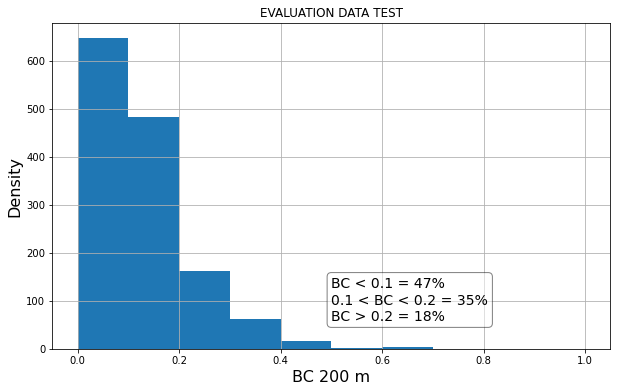

In [52]:
fig = plt.figure(figsize=(10,6))
bin = np.linspace(0,1,11)
plt.hist(list_bhatta, bins=bin, density=False)
plt.grid()
plt.ylabel('Density',size = 16)
plt.xlabel('BC 200 m',size = 16)
coef = list_bhatta.shape[0]/100

BC01 = np.sum(np.where(list_bhatta <0.1,1,0))/coef
BC02 = np.sum(np.where(list_bhatta >0.2,1,0))/coef
BC03 = (list_bhatta.shape[0] - BC01*coef - BC02*coef)/coef

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'BC < 0.1 = '+str(round(BC01))+'%'+'\n'+'0.1 < BC < 0.2 = '+str(round(BC03))+'%'+'\n'+'BC > 0.2 = '+str(round((BC02)))+'%'
# place a text box in upper left in axes coords
plt.text(0.5, 150, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('EVALUATION DATA TEST')



<ipython-input-56-8ec5d2f301ed>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon, lat,image_test[i+gap,-1,:,:].T,cmap = plt.cm.RdBu)


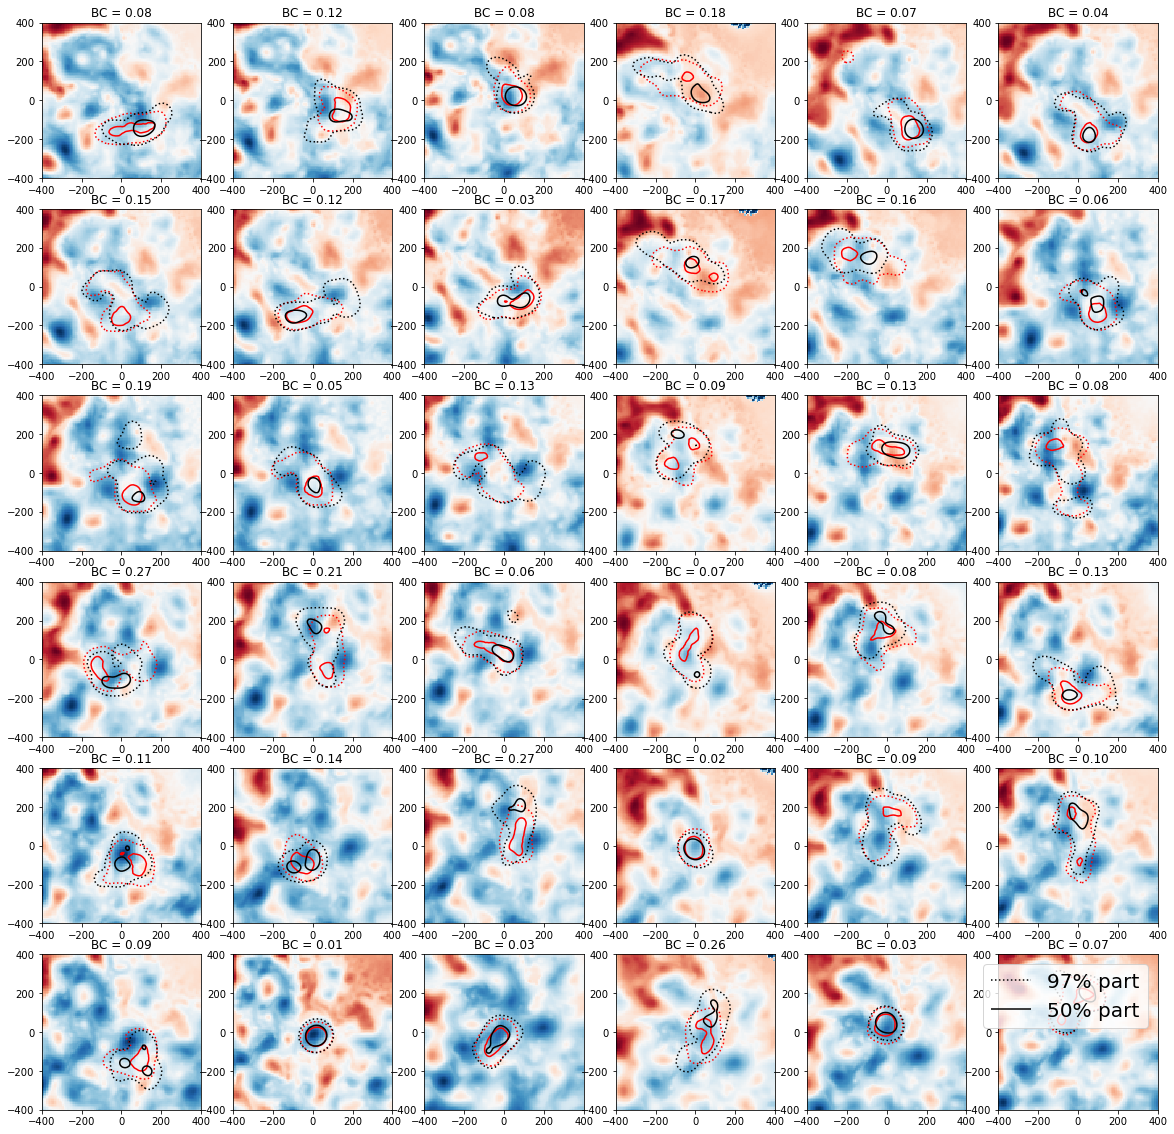

In [56]:
lon = np.linspace(-400,400,nb_dx)
lat = np.linspace(-400,400,nb_dx)
levels = [0.0002,0.0025]
#levels = np.linspace(0.0001,0.01,5)
fig = plt.figure(figsize=(20,20))
gap = 400


for i in range(36):
    ax = fig.add_subplot(6,6,i+1)
    plt.pcolormesh(lon, lat,image_test[i+gap,-1,:,:].T,cmap = plt.cm.RdBu)
    plt.contour(lon, lat,super_model_norm[i+gap,:,:].T,levels=levels,colors=['red','red'],linestyles=['dotted','-'])
    CS = plt.contour(lon, lat,pdf_filter_test[i+gap,-1,:,:].T,levels=levels,colors=['k','k'],linestyles=['dotted','-'])
    plt.title('BC = {:.2f}'.format(list_bhatta[i+gap]))
    

CS.collections[0].set_label('97% part')
CS.collections[1].set_label('50% part')
ax.legend(prop={'size': 20},loc = 'upper right')

# Save supermodel 4L

In [7]:

#creating the file
nc = nc4.Dataset('supermodel_4L.nc','w')

nc.createDimension('nbsample', pdf_filter_test.shape[0])
nc.createDimension('dx', 100)
nc.createDimension('dy', 100)

nc.createVariable('super_model_norm', 'f8', ('nbsample','dx','dy'))
nc.variables['super_model_norm'][:,:,:] = super_model_norm[:,:,:]
nc.close()


# Supermodel surface

In [3]:
### LOAD ALL DATA ####

(image_test,pdf_test,pdf_filter_test) = load_data_test_surface_all()
(image_test,pdf_test,pdf_filter_test) = (image_test[:-28],pdf_test[:-28],pdf_filter_test[:-28])
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)

test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)

Loading simu2 surface data ...
Done
Loading pdf simu2 ...
Pdf simu2 loaded
Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded


In [ ]:
# Save direction and type of cn
device='cuda'

super_model = np.zeros((pdf_test.shape[0],100,100))
super_model_norm = np.zeros((pdf_test.shape[0],100,100))
prediction_10 = np.zeros((10,batch_size,100,100))
#prediction_10_last = np.zeros((10,20,100,100))
i = 0

kernel_size=5
padding=2
bias=False
p_dropout=0
nlayer0=64
nb_inputs = 28 #28

dirSAVE = '../DATA/Saved_model'

pdf_10 = np.zeros((10,image_test.shape[0],100,100))


with torch.no_grad():
    for batch, (X, y_filter, y) in enumerate(test_loader):
        # TRAIN MODEL
        X, y_filter, y = X.to(device), y_filter.to(device), y.to(device)
        
        for j in range(0,10):
        
            autoencoder = CNN_UNET_generic.load_from_checkpoint(dirSAVE+'/supermodel/CNN_UNET_k5_p2_bFalse_d0_nl64_ni_28_{0}.ckpt'.format(j),kernel_size=kernel_size,padding=padding,bias=bias,p_dropout=p_dropout,nlayer0=nlayer0,nb_inputs=nb_inputs).to(device)
            filename_chkpt = 'CNN_UNET_k{0}_p{1}_b{2}_d{3}_nl{4}_ni_{5}_{6}'.format(kernel_size,padding,bias,p_dropout,nlayer0,nb_inputs,j)
            prediction_test = autoencoder(X,y_filter,y)[:,-1,:,:]
            prediction_10[j,:,:,:] = prediction_test.cpu().detach().numpy()
        
        pdf_10[:,i*32:i*32+32,:,:] = prediction_10
        prediction_10 = np.sort(prediction_10,axis=0)
        super_model[batch_size*i:batch_size*i+batch_size,:,:] = np.median(prediction_10,axis=0)
        
        #print(i)
        i = i+1

for i in range(pdf_test.shape[0]):
    super_model_norm[i,:,:] = super_model[i,:,:]/np.sum(super_model[i,:,:])

# Checking

In [15]:
list_bhatta = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_norm[i,:,:], pdf_filter_test[i,-1,:,:])))))
np.mean(list_bhatta)

0.18141957710183607

In [16]:
list_10_models_bhatta = np.zeros((pdf_filter_test.shape[0],10))
for i in range(pdf_filter_test.shape[0]):
    for j in range(10):
        list_10_models_bhatta[i,j] = 1 - np.sum(np.sqrt(np.abs((np.multiply(pdf_10[j,i,:,:], pdf_filter_test[i,-1,:,:])))))


Text(0.5, 1.0, 'EVALUATION DATA TEST')

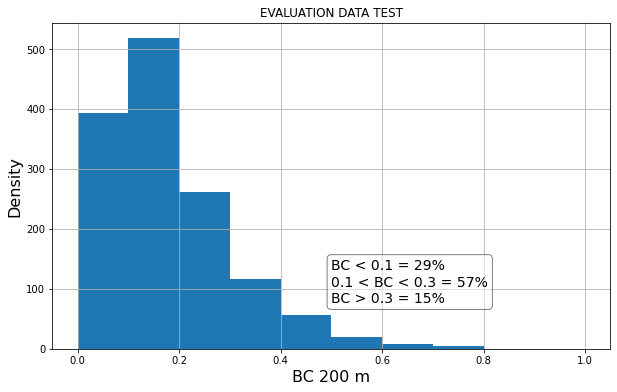

In [5]:
fig = plt.figure(figsize=(10,6))
bin = np.linspace(0,1,11)
plt.hist(list_bhatta, bins=bin, density=False)
plt.grid()
plt.ylabel('Density',size = 16)
plt.xlabel('BC 200 m',size = 16)
coef = list_bhatta.shape[0]/100

BC01 = np.sum(np.where(list_bhatta <0.1,1,0))/coef
BC02 = np.sum(np.where(list_bhatta >0.3,1,0))/coef
BC03 = (list_bhatta.shape[0] - BC01*coef - BC02*coef)/coef

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'BC < 0.1 = '+str(round(BC01))+'%'+'\n'+'0.1 < BC < 0.3 = '+str(round(BC03))+'%'+'\n'+'BC > 0.3 = '+str(round((BC02)))+'%'
# place a text box in upper left in axes coords
plt.text(0.5, 150, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('EVALUATION DATA TEST')

In [ ]:
from matplotlib import ticker, cm

lon = np.linspace(-400,400,nb_dx)
lat = np.linspace(-400,400,nb_dx)
levels = [0.0002,0.001]
#levels = np.linspace(0.0001,0.01,5)
fig = plt.figure(figsize=(20,20))
gap = 600


for i in range(36):
    ax = fig.add_subplot(6,6,i+1)
    #plt.pcolormesh(lon, lat,pdf_test_filter[index_non_valid[0][i+gap],-1,0,:,:])
    plt.pcolormesh(lon, lat,image_test[i+gap,0,:,:].T,cmap = plt.cm.RdBu)
    plt.contour(lon, lat,super_model_norm[i+gap,:,:].T,levels=levels,colors=['red','red'],linestyles=['dotted','-'])
    plt.contour(lon, lat,pdf_filter_test[i+gap,-1,:,:].T,levels=levels,colors=['k','k'],linestyles=['dotted','-'])
    plt.title('BC = {:.2f}'.format(list_bhatta[i+gap]))

# save supermodel surface

In [ ]:

#creating the file
nc = nc4.Dataset('supermodel_surf.nc','w')

nc.createDimension('nbsample', pdf_filter_test.shape[0])
nc.createDimension('dx', 100)
nc.createDimension('dy', 100)

nc.createVariable('super_model_norm', 'f8', ('nbsample','dx','dy'))
nc.variables['super_model_norm'][:,:,:] = super_model_norm[:,:,:]
nc.close()
